### 1. Init the environment and import packages

In [577]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

### 2. Load the train.csv file, and look into some general information of these data

In [578]:
# Load the dataset csv file
train_data = pd.read_csv('../dataset/train.csv')
train_data.info()
test_data = pd.read_csv('../dataset/test.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [579]:
# Retrieve all the numeric columns
train_data.describe()
dtypes = train_data.select_dtypes(include=np.number)
print(dtypes)

     PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare
0              1         0       3  22.0      1      0   7.2500
1              2         1       1  38.0      1      0  71.2833
2              3         1       3  26.0      0      0   7.9250
3              4         1       1  35.0      1      0  53.1000
4              5         0       3  35.0      0      0   8.0500
..           ...       ...     ...   ...    ...    ...      ...
886          887         0       2  27.0      0      0  13.0000
887          888         1       1  19.0      0      0  30.0000
888          889         0       3   NaN      1      2  23.4500
889          890         1       1  26.0      0      0  30.0000
890          891         0       3  32.0      0      0   7.7500

[891 rows x 7 columns]


### 3. Look into the numeric features

In [580]:
# Separate numeric columns
df_num = train_data[['Age', 'SibSp', 'Parch', 'Fare']]
df_num.describe()


,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


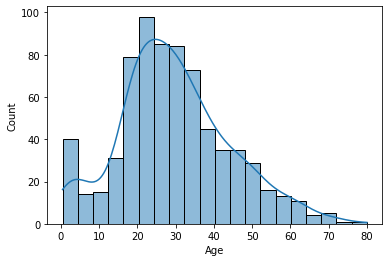

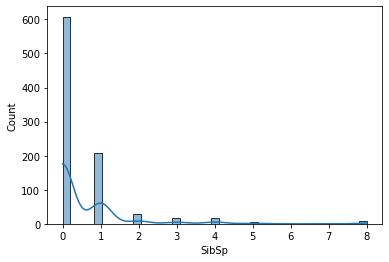

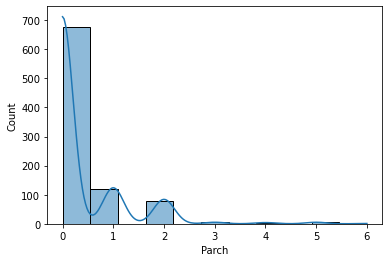

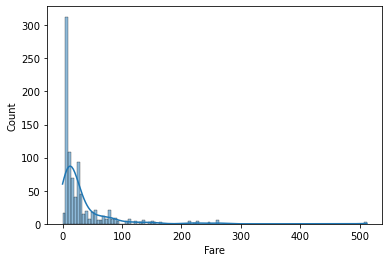

In [581]:
# Show stats of each numeric column
for i in df_num.columns:
    sns.histplot(data=train_data, x=df_num[i], kde=True)
    plt.show()


            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<AxesSubplot:>

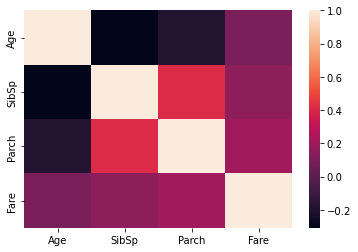

In [582]:
corr = df_num.corr()
print(corr)
sns.heatmap(corr)


In [583]:
# Show stats in different numerics by survival.
pd.pivot_table(train_data, index=['Survived'], values=['Age', 'SibSp', 'Parch', 'Fare'], aggfunc=['mean', 'median'])


mean                                median                  
                Age       Fare     Parch     SibSp    Age  Fare Parch SibSp
Survived                                                                   
0         30.626179  22.117887  0.329690  0.553734   28.0  10.5     0     0
1         28.343690  48.395408  0.464912  0.473684   28.0  26.0     0     0

### 4. show categorial features

After analyzed all the data, we can see some categorial columns that contribute to the survived result significantly.
There are three columns thate are obviously related to the survived result.
1. Pclass: survived ratios are 62.96% for 1st class, 47.28% for 2nd class and 24.24% for 3rd class.
2. Sex: survived ratio are 74.20% for female and 18.89% for male.
3. Embarked: survived rate are 10.44% for embarked at C, 38.96% for embarked at Q and 33.70% for embarked at S .

In [584]:
# Separate category columns
df_cat = train_data[['Survived', 'Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']]
df_cat.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Survived  891 non-null    int64 
 1   Pclass    891 non-null    int64 
 2   Name      891 non-null    object
 3   Sex       891 non-null    object
 4   Ticket    891 non-null    object
 5   Cabin     204 non-null    object
 6   Embarked  889 non-null    object
dtypes: int64(2), object(5)
memory usage: 48.9+ KB


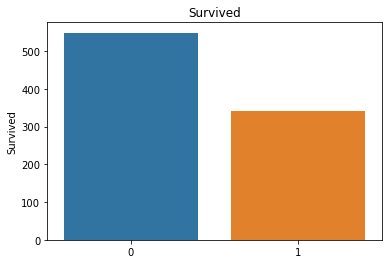

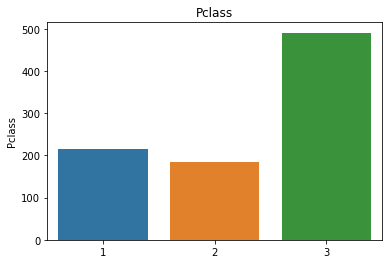

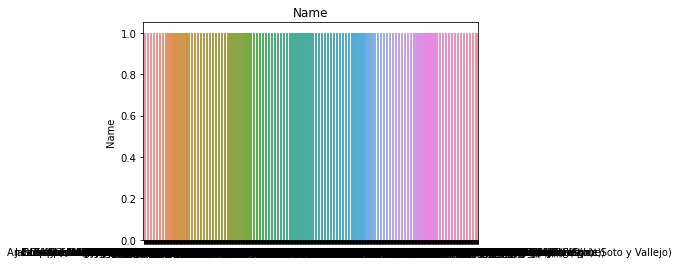

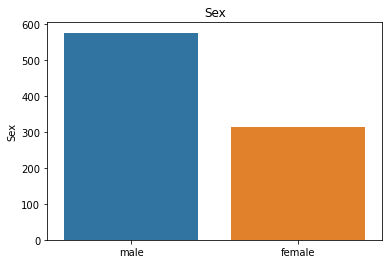

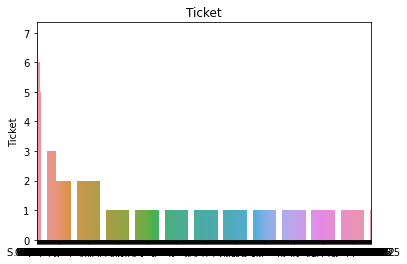

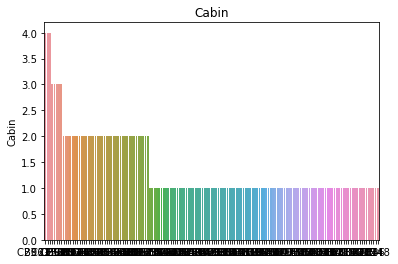

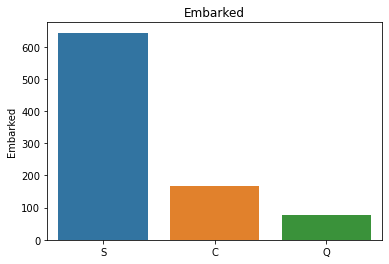

In [585]:
# Show stats of each category colums
for i in df_cat.columns:
    sns.barplot(x=df_cat[i].value_counts().index, y=df_cat[i].value_counts()).set_title(i)
    plt.show()


In [586]:
# Compute the suvived ratio of each Pclass. Though the total people in 3rd class is much more than the 1st class, the number of survived
# people is reversed.
# In terms of survived ratio between each Pclass, they are 62.96% for 1st class, 47.28% for 2nd class and 24.24% for 3rd class.
first_cls_survived = train_data.loc[train_data.Pclass == 1]['Survived']
first_cls_survived_ratio = sum(first_cls_survived) / len(first_cls_survived)
first_cls_survived_ratio_ofall = sum(first_cls_survived) / len(train_data)
print('the first class survived ratio among all passengers is {}, the survived ratio among all first class passengers is {}'.format
      (first_cls_survived_ratio_ofall, first_cls_survived_ratio))

second_cls_survived = train_data.loc[train_data.Pclass == 2]['Survived']
second_cls_survived_ratio = sum(second_cls_survived) / len(second_cls_survived)
second_cls_survived_ratio_ofall = sum(second_cls_survived) / len(train_data)
print('the second class survived ratio among all passengers is {}, the survived ratio among all second class passengers is {}'.format
      (second_cls_survived_ratio_ofall, second_cls_survived_ratio))

third_cls_survived = train_data.loc[train_data.Pclass == 3]['Survived']
third_cls_survived_ratio = sum(third_cls_survived) / len(third_cls_survived)
thrid_cls_survived_ratio_ofall = sum(third_cls_survived) / len(train_data)
print('the third class survived ratio among all passengers is {}, the survived ratio among all third class passengers is {}'.format
      (thrid_cls_survived_ratio_ofall, third_cls_survived_ratio))

the first class survived ratio among all passengers is 0.1526374859708193, the survived ratio among all first class passengers is 0.6296296296296297
the second class survived ratio among all passengers is 0.09764309764309764, the survived ratio among all second class passengers is 0.47282608695652173
the third class survived ratio among all passengers is 0.1335578002244669, the survived ratio among all third class passengers is 0.24236252545824846


In [587]:
# Show how many people survived or not in each Sex
# The result shows that female survived much more than male. Among the female, the survived ratio is 74.20%, compared to 18.89% of male
train_data.groupby(['Survived', 'Sex']).size()


Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
dtype: int64

In [588]:
# Compute the survived ratio of each Sex type
female_survived = train_data.loc[train_data.Sex == 'female']['Survived']
female_survived_ratio = sum(female_survived) / len(female_survived)
female_survived_ratio_ofall = sum(female_survived) / len(train_data)
print('the female survived ratio among all passengers is {}, the survived ratio among all female passengers is {}'.format
      (female_survived_ratio_ofall, female_survived_ratio))

male_survived = train_data[train_data.Sex == 'male']['Survived']
male_survived_ratio = sum(male_survived) / len(male_survived)
male_survived_ratio_ofall = sum(male_survived) / len(train_data)
print('the male survived ratio among all passengers is {}, the survived ratio among all male passengers is {}'.format
      (male_survived_ratio_ofall, male_survived_ratio))


the female survived ratio among all passengers is 0.2615039281705948, the survived ratio among all female passengers is 0.7420382165605095
the male survived ratio among all passengers is 0.122334455667789, the survived ratio among all male passengers is 0.18890814558058924


In [589]:
# Embarked: (C = Cherbourg; Q =Queenstown; S =Southampton)
# The result shows that people embarked at Southampton have the least chance to survive.
train_data.groupby(['Survived', 'Embarked']).size()

Survived  Embarked
0         C            75
          Q            47
          S           427
1         C            93
          Q            30
          S           217
dtype: int64

In [590]:
# Compute the survived ratio of each Embarked
c_survived = train_data.loc[train_data.Embarked == 'C']['Survived']
c_survived_ratio = sum(c_survived) / len(c_survived)
c_survived_ratio_ofall = sum(c_survived) / len(train_data)
print('the embarked at C survived ratio among all passengers is {}, the survived ratio among all embarked at C passengers is {}'.format
      (c_survived_ratio_ofall, c_survived_ratio_ofall))

q_survived = train_data.loc[train_data.Embarked == 'Q']['Survived']
q_survived_ratio = sum(q_survived) / len(q_survived)
q_survived_ratio_ofall = sum(q_survived) / len(train_data)
print('the embarked at Q survived ratio among all passengers is {}, the survived ratio among all embarked at Q passengers is {}'.format
      (q_survived_ratio_ofall, q_survived_ratio))

s_survived = train_data.loc[train_data.Embarked == 'S']['Survived']
s_survived_ratio = sum(s_survived) / len(s_survived)
s_survived_ratio_ofall = sum(s_survived) / len(train_data)
print('the embarked at S survived ratio among all passengers is {}, the survived ratio among all embarked at S passengers is {}'.format
      (s_survived_ratio_ofall, s_survived_ratio))


the embarked at C survived ratio among all passengers is 0.10437710437710437, the survived ratio among all embarked at C passengers is 0.10437710437710437
the embarked at Q survived ratio among all passengers is 0.03367003367003367, the survived ratio among all embarked at Q passengers is 0.38961038961038963
the embarked at S survived ratio among all passengers is 0.24354657687991021, the survived ratio among all embarked at S passengers is 0.33695652173913043


### 5. Feature Engineering

We have missing values for Age, Cabin in all dataset, only missing Fare in Test dataset, and Embarked in training dataset.

* Name -> we can extract the Title from Name, then analyse the Correlation coefficient between Title and Survived
* Age -> The data is almost normally distributed, so we can impute the value using mean. Also try median value later for a better
optimization.
* Cabin -> All dataset have more than 70% missing values in this category, we can drop this column.
* Embarked -> Remove the row of missing value in this category because there are only two rows of missing value of Embarked.


In [591]:
# handling missing value training data. use the mean value for missing Age.
train_data['Age'].fillna(train_data['Age'].mean(), inplace=True)
train_data['Fare'].fillna(train_data['Fare'].mean(), inplace=True)
# train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
train_data.dropna(subset=['Embarked'], axis=0, inplace=True)

# handling missing value test data
test_data['Age'].fillna(train_data['Age'].mean(), inplace=True)
test_data['Fare'].fillna(train_data['Fare'].mean(), inplace=True)
# test_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data.dropna(subset=['Embarked'], axis=0, inplace=True)

In [592]:
# Extract Title from Name
for dataframe in (train_data, test_data):
    dataframe['Title'] = dataframe['Name'].apply(lambda s: s.split(',')[1].split('.')[0].strip())

In [593]:
# drop the name, ticket, cabin columns

for dataframe in (train_data, test_data):
    dataframe.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

### 6. Data preprocessing

In [594]:
# Original data

X_train = train_data.drop(columns=['Survived', 'PassengerId'])
y_train = train_data['Survived']

X_test = test_data.drop(columns=['Survived', 'PassengerId'])
y_test = test_data['Survived']


In [595]:
preprocess = make_column_transformer(
    (OrdinalEncoder(), ['Sex', 'Pclass']),
    (OneHotEncoder(handle_unknown='ignore'), ['Embarked', 'Title']),
    (StandardScaler(), ['Age', 'SibSp', 'Parch', 'Fare'])
)

pipeline = Pipeline([
    ('preprocess', preprocess),
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

### 7. Choose the best Model


#### 1. LogisticRegression Model

In [596]:
lr = LogisticRegression(max_iter=2000)
cv = cross_val_score(lr, X_train_transformed, y_train, cv=5)
print(cv)
print(cv.mean())


[0.83707865 0.82022472 0.80337079 0.79775281 0.86440678]
0.8245667491906303


#### 2. RandomForestClassifier Model


In [597]:
rf = RandomForestClassifier(random_state=1)
cv = cross_val_score(rf, X_train_transformed, y_train, cv=5)
print(cv)
print(cv.mean())

[0.79775281 0.79213483 0.85393258 0.75842697 0.81920904]
0.8042912461118517


#### 3. DecisionTreeClassifier Model

In [598]:
dt = DecisionTreeClassifier(random_state=1)
cv = cross_val_score(dt, X_train_transformed, y_train, cv=5)
print(cv)
print(cv.mean())

[0.76404494 0.75280899 0.83146067 0.71910112 0.77966102]
0.7694153494572462


### Fine-tune the model

In [599]:
# Since we only have small dataset, so only use liblinear in solver. then the penalty is l1 and l2
model_params = {
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear'),
        'params': {
            'penalty': ['l1', 'l2'],
            'C': [1, 10, 100, 1000, 5000, 10000],
        }
    },
    'random_forests': {
        'model': RandomForestClassifier(random_state=1),
        'params': {
            'n_estimators': [1, 5, 10, 50, 100, 200],
            'max_depth': [1, 5, 10, 20],
        }
    },
    'decision_trees': {
        'model': DecisionTreeClassifier(random_state=1),
        'params': {
            'max_depth': [1, 5, 10, 20],
        }
    }
}

result_scores = []
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train_transformed, y_train)
    result_scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

df = pd.DataFrame(result_scores, columns=['model', 'best_score', 'best_params'])
df

D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


,model,best_score,best_params
0,logistic_regression,0.826827,"{'C': 1000, 'penalty': 'l1'}"
1,random_forests,0.825671,"{'max_depth': 10, 'n_estimators': 100}"
2,decision_trees,0.812195,{'max_depth': 5}


In [600]:
### Use the best model with the params from above

lr = LogisticRegression(solver='liblinear', penalty='l2', C=5000)
lr.fit(X_train_transformed, y_train)
y_pred = lr.predict(X_test_transformed).astype(int)
lr_acc = accuracy_score(y_test, y_pred)
print('The Prediction Results of Logistic Regression:')
print(y_pred)
print(lr_acc)
print(classification_report(y_test, y_pred))


The Prediction Results of Logistic Regression:
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 0 1 1 1 1 1 0 1 0 0 1]
0.7727272727272727
              precision    recall  f1-score   support

           0       0.83      0